In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load Data: ESM2M

## Population Data

In [2]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

## Capacity Data

In [3]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [4]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_esm2m = lf.calc_baseline(ds_esm2m).compute()

[########################################] | 100% Completed | 38.0s


In [5]:
# Shorten capacity dataset to 2000-2100
ds_esm2m = ds_esm2m.sel(time=slice('2000-01-31',None))['capacity']

## Calculate ToEs

In [6]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.9,0.75,0.5]

# Calculate ToEs for all grid cells and ensemble members
with ProgressBar():
    ds_toe_esm2m = lf.toe_summer(ds_esm2m,ds_base_esm2m,labor_thres).compute()

[########################################] | 100% Completed |  2min 40.3s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s


# Load Data: CESM2

## Population Data

In [7]:
# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2_2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)

## Capacity Data

In [8]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [9]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_cesm2 = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed |  1min 12.3s


In [10]:
# Shorten capacity dataset to 2000-2100
ds_cesm2 = ds_cesm2.sel(time=slice('2000-01-31',None))['capacity']

## Calculate ToEs

In [11]:
# Labor reduction thresholds and frequency threshold (# reduced months per year) used to define ToE
labor_thres = [0.9,0.75,0.5]

with ProgressBar():
    # Calculate ToEs for all grid cells and ensemble members
    ds_toe_cesm2 = lf.toe_summer(ds_cesm2,ds_base_cesm2,labor_thres).compute()

[########################################] | 100% Completed |  5min 40.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.0s


# Spatial Maps

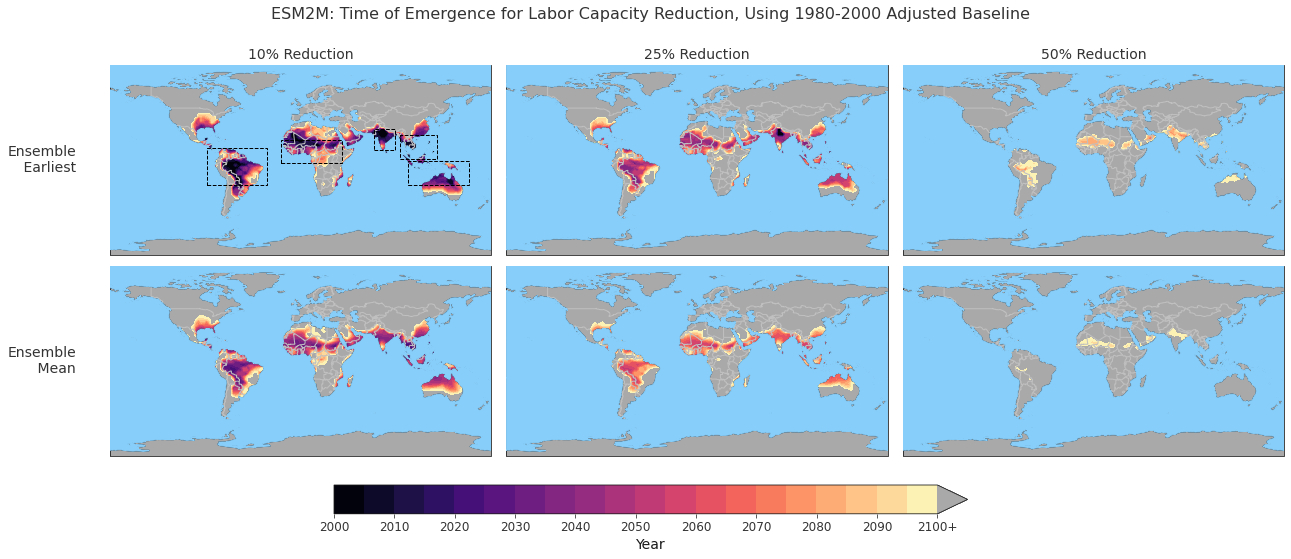

In [20]:
lf.spatial_toe(ds_toe_esm2m,'ESM2M: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline',['0.9','0.75','0.5'])

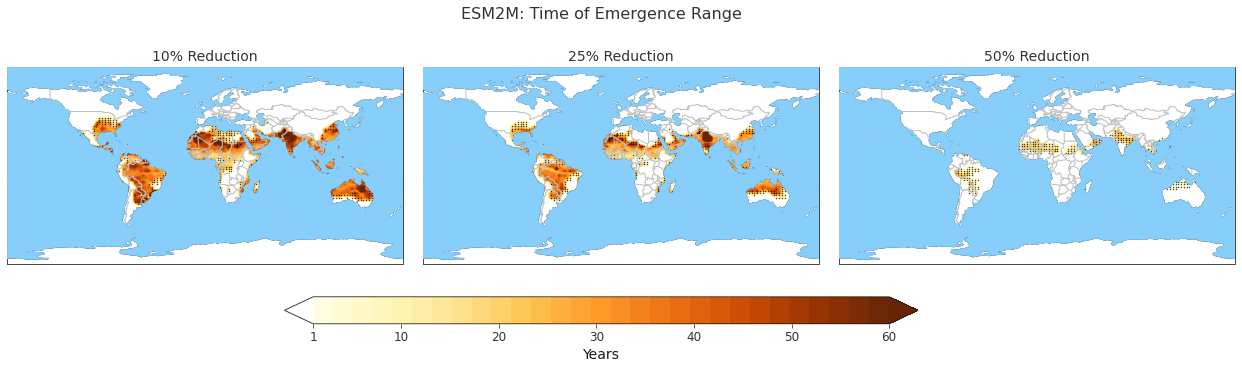

In [22]:
lf.spatial_toe_diff(ds_toe_esm2m,'ESM2M: Time of Emergence Range',['0.9','0.75','0.5'],s=0.5)

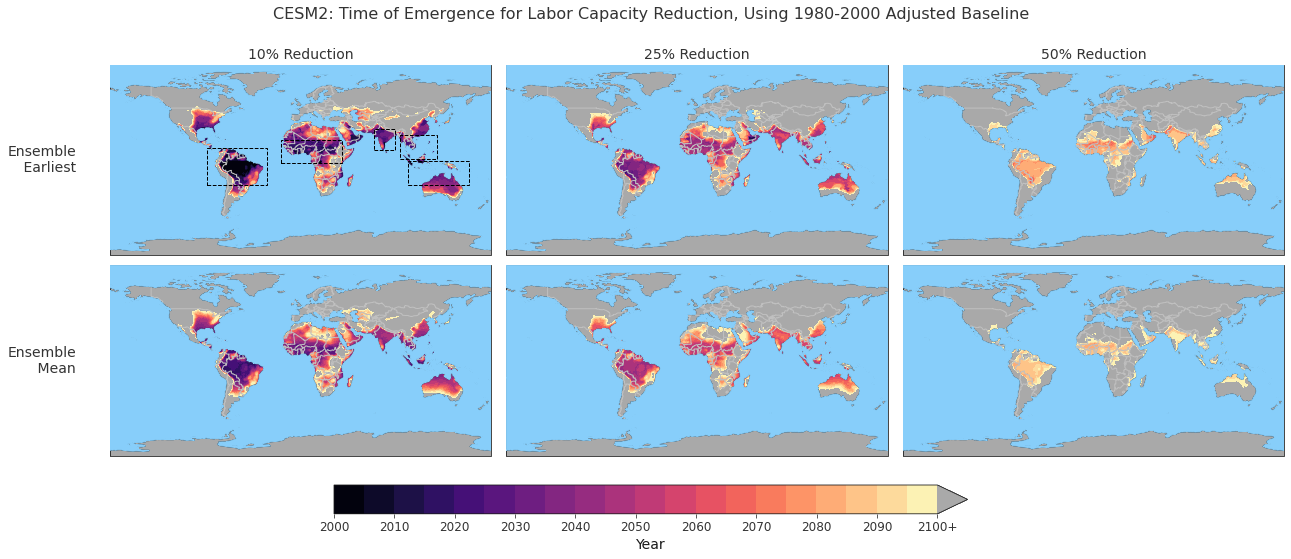

In [27]:
lf.spatial_toe(ds_toe_cesm2,'CESM2: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline',['0.9','0.75','0.5'])

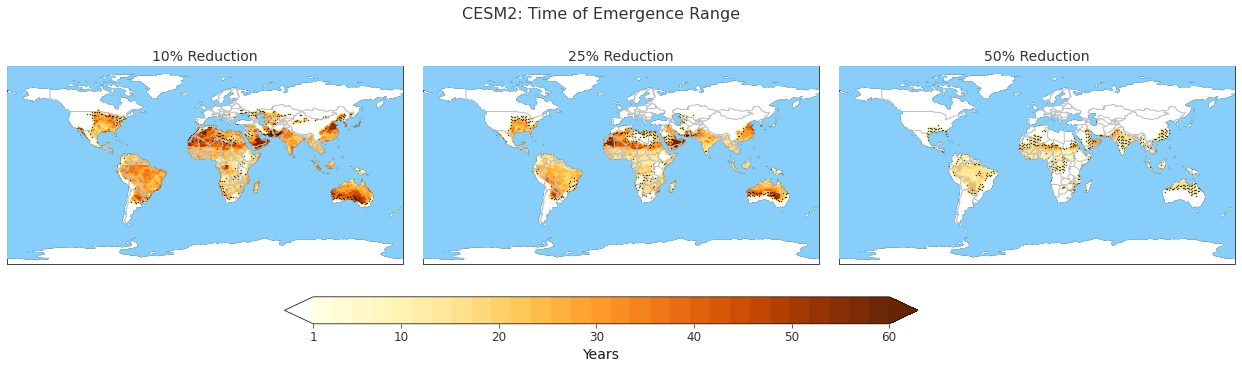

In [29]:
lf.spatial_toe_diff(ds_toe_cesm2,'CESM2: Time of Emergence Range',['0.9','0.75','0.5'],s=0.5,reduce=True)

# Bar Chart

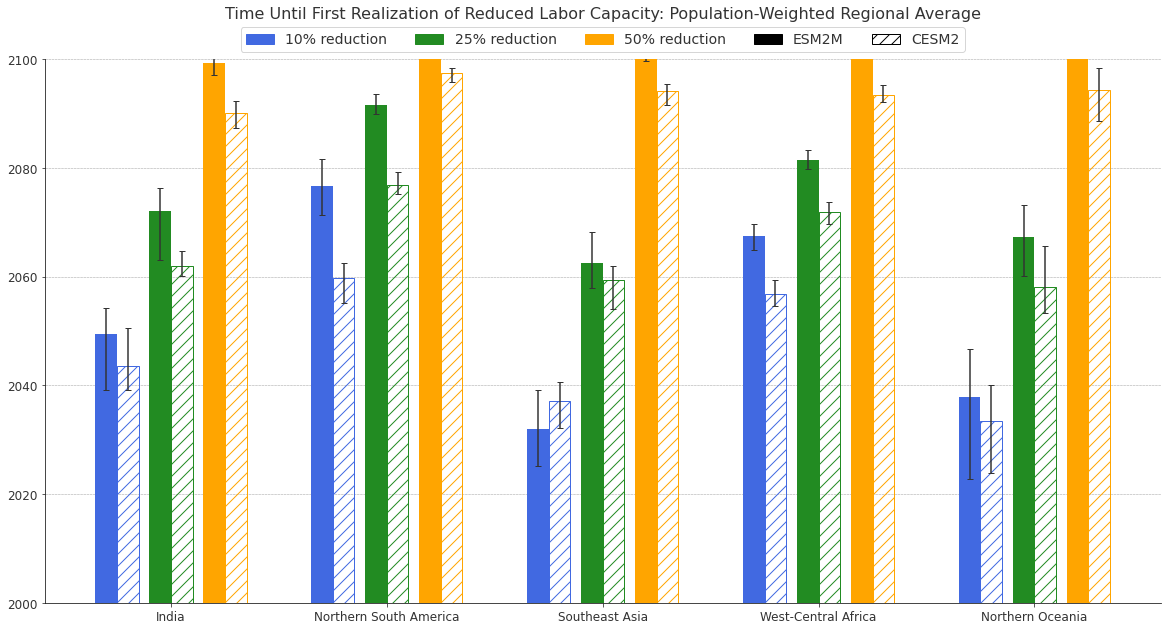

In [30]:
# Regions to plot
regions = ['India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']
thres = ['0.9','0.75','0.5']

# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.1

fig, ax = plt.subplots(figsize=(20,10))

# Loop through locations alloted to regions
for x in locs:
    region = regions[x]
    
    # Get ToEs for grid cells in region
    ds_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    ds_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')

    # Population-weighted average ToE
    esm2m_avg = ds_esm2m.weighted(ds_pop_esm2m).mean(['lon','lat'])
    cesm2_avg = ds_cesm2.weighted(ds_pop_cesm2).mean(['lon','lat'])

    # errors_above = upper error bar; errors_below = lower error bar
    errors_esm2m_above = esm2m_avg.max('ensemble')-esm2m_avg.mean('ensemble')
    errors_esm2m_below = esm2m_avg.mean('ensemble')-esm2m_avg.min('ensemble')

    errors_cesm2_above = cesm2_avg.max('ensemble')-cesm2_avg.mean('ensemble')
    errors_cesm2_below = cesm2_avg.mean('ensemble')-cesm2_avg.min('ensemble')
    
    # color of error bar
    ec = (0.2,0.2,0.2)
    
    # Draw bars for 10% threshold
    # yerr format: [[Lower error],[Upper error]]
    ax.bar(x-3*width,esm2m_avg[thres[0]].mean('ensemble'),width,yerr=[[errors_esm2m_below[thres[0]]],[errors_esm2m_above[thres[0]]]],color='royalblue',ecolor=ec)
    ax.bar(x-2*width,cesm2_avg[thres[0]].mean('ensemble'),width,yerr=[[errors_cesm2_below[thres[0]]],[errors_cesm2_above[thres[0]]]],edgecolor='royalblue',fill=False,hatch='//',ecolor=ec)
    
    # Draw bars for 20% threshold
    ax.bar(x-0.5*width,esm2m_avg[thres[1]].mean('ensemble'),width,yerr=[[errors_esm2m_below[thres[1]]],[errors_esm2m_above[thres[1]]]],color='forestgreen',ecolor=ec)
    ax.bar(x+0.5*width,cesm2_avg[thres[1]].mean('ensemble'),width,yerr=[[errors_cesm2_below[thres[1]]],[errors_cesm2_above[thres[1]]]],edgecolor='forestgreen',fill=False,hatch='//',ecolor=ec)
    
    # Draw bars for 30% threshold
    ax.bar(x+2*width,esm2m_avg[thres[2]].mean('ensemble'),width,yerr=[[errors_esm2m_below[thres[2]]],[errors_esm2m_above[thres[2]]]],color='orange',ecolor=ec)
    ax.bar(x+3*width,cesm2_avg[thres[2]].mean('ensemble'),width,yerr=[[errors_cesm2_below[thres[2]]],[errors_cesm2_above[thres[2]]]],edgecolor='orange',fill=False,hatch='//',ecolor=ec)

# Region labels
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds + models
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_patch = mpatches.Patch(color='black', label='ESM2M')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_patch,hatch_patch],ncol=5,loc='lower center',bbox_to_anchor=(0.5,1));

ax.set_title('Time Until First Realization of Reduced Labor Capacity: Population-Weighted Regional Average\n\n',fontsize=16);

# Time Series

In [37]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.9','0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    # Thresholds for ESM2M
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[0]].min(dim='ensemble'),ds_frac_esm2m[thres[0]].max(dim='ensemble'),alpha=0.15,color='royalblue')
    # Plot ensemble mean
    ds_frac_esm2m[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[1]].min(dim='ensemble'),ds_frac_esm2m[thres[1]].max(dim='ensemble'),alpha=0.15,color='forestgreen')
    ds_frac_esm2m[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[2]].min(dim='ensemble'),ds_frac_esm2m[thres[2]].max(dim='ensemble'),alpha=0.15,color='orange')
    ds_frac_esm2m[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linewidth=3)

    # Thresholds for CESM2
    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[0]].min(dim='ensemble'),ds_frac_cesm2[thres[0]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='royalblue',linewidth=1.5)
    ds_frac_cesm2[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[1]].min(dim='ensemble'),ds_frac_cesm2[thres[1]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='forestgreen',linewidth=1.5)
    ds_frac_cesm2[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[2]].min(dim='ensemble'),ds_frac_cesm2[thres[2]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='orange',linewidth=1.5)
    ds_frac_cesm2[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linestyle='dashed',linewidth=3)
    
    # Set labels, limits, title
    ax.set_xlabel('Year')
    ax.set_ylabel('Fraction of Population')
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title)

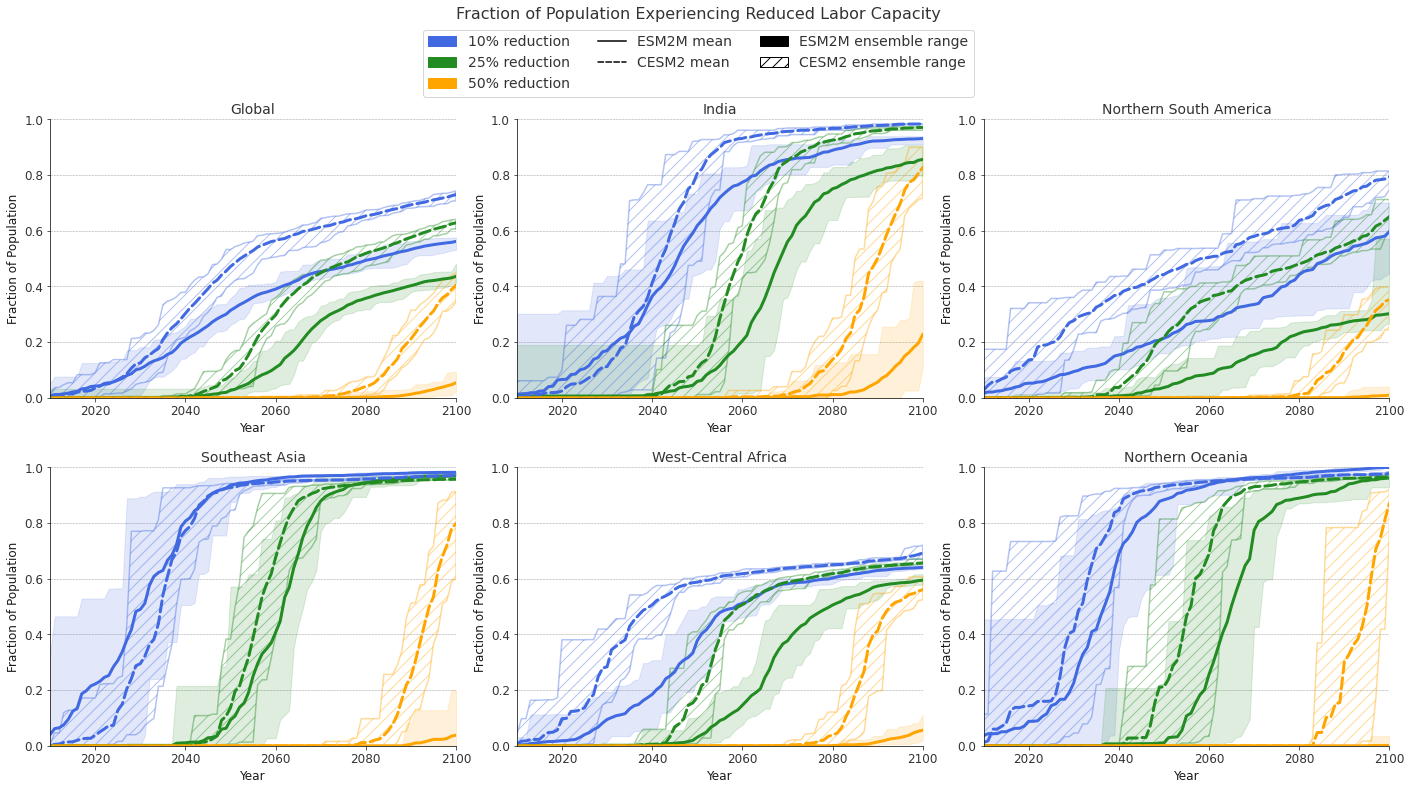

In [38]:
# Regions to plot
regions = ['Global','India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']

# Create figure and axes
fig, axs = plt.subplots(figsize=(24,12),nrows=2,ncols=3)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/3)][index%3]
    index+=1
    
    # Get ToE and population data for region
    ds_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    ds_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    frac_emerge_plot(ds_esm2m,ds_cesm2,pop_esm2m,pop_cesm2,region,ax)

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

# Create axis at top for legend
fig.subplots_adjust(top=0.85)
legend_ax = fig.add_axes([0.3, 0.875, 0.4, 0.08])
legend_ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.15,hspace=.25)
fig.suptitle('Fraction of Population Experiencing Reduced Labor Capacity',fontsize=16);

# Event Plot

In [39]:
regions = ['India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']
thres = ['0.9','0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()
esm2m_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_3[region] = ds_region[thres[2]].weighted(ds_pop_esm2m).mean(['lat','lon'])

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')
esm2m_3 = esm2m_3.to_array(dim='region')

In [40]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()
cesm2_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_3[region] = ds_region[thres[2]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')
cesm2_3 = cesm2_3.to_array(dim='region')

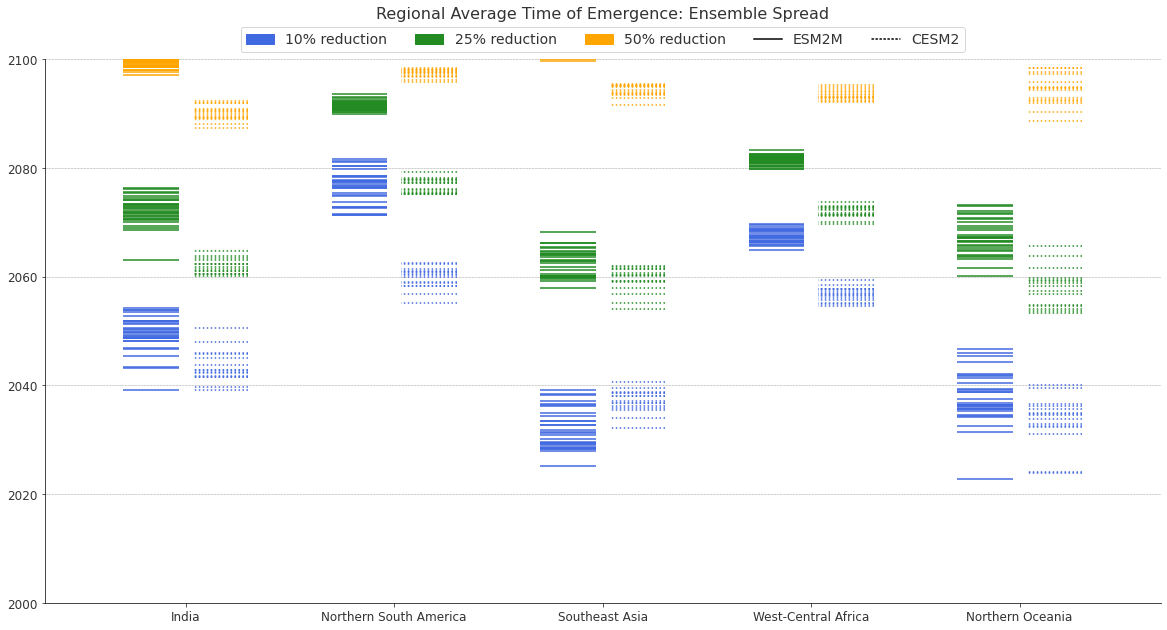

In [41]:
fig,ax=plt.subplots(figsize=(20,10))
ax.eventplot(esm2m_1,orientation='vertical',colors='royalblue',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_2,orientation='vertical',colors='forestgreen',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_3,orientation='vertical',colors='orange',linelengths=0.8,lineoffsets=[1,4,7,10,13]);

ax.eventplot(cesm2_1,orientation='vertical',colors='royalblue',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_2,orientation='vertical',colors='forestgreen',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_3,orientation='vertical',colors='orange',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);

locs = np.arange(1.5,16.5,3)
ax.set_xticks(locs)
ax.set_xticklabels(regions);
ax.set_ylim([2000,2100]);
ax.set_title('Regional Average Time of Emergence: Ensemble Spread\n\n',fontsize=16);

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));